In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from diffusion_FEM import Diffusion

In [2]:
# problem parameters
lenght_x, length_y = 10, 10  # domain size
source = 0 #-1  # source term

# load mesh from hdf5 file
f = h5py.File('disks_gmsh.h5', 'r')
coords_x = np.array(f['coords_x'], dtype=float)
coords_y = np.array(f['coords_y'], dtype=float)
node = np.column_stack((coords_x, coords_y))
elem = np.array(f['elem'], dtype=int)
material_domains = np.array(f['material'], dtype=int)
f.close()

def material_as_vector(material_domains,parameters):
    vec = np.zeros_like(material_domains)
    for i in range(len(parameters)):
        vec[material_domains == i] = parameters[i]
    return vec

material = material_as_vector(material_domains,parameters = np.array([200,1,300]))

# boundary conditions
side_left = coords_x == 0
side_right = coords_x == lenght_x
nodes_Dirichlet = side_left | side_right
values_Dirichlet = np.zeros((node.shape[0],))
values_Dirichlet[side_left] = 80
values_Dirichlet[side_right] = 10
values_Dirichlet = values_Dirichlet[nodes_Dirichlet]

In [3]:

my_diffusion = Diffusion(node=node, elem=elem, nodes_Dirichlet=nodes_Dirichlet, values_Dirichlet=values_Dirichlet, material=material, source=source)
my_diffusion.assemble_system()
my_diffusion.solve()
measurement_points = np.where((my_diffusion.coords_y == 0) & ((my_diffusion.coords_x > 4) & (my_diffusion.coords_x<6)))[0]

def forward_model(parameters):
    material = material_as_vector(material_domains,parameters)
    my_diffusion.change_material(material)
    # my_diffusion.assemble_system()
    my_diffusion.solve()
    return my_diffusion.get_state_function_observations(measurement_points)

print(forward_model([200, 1, 300]))
print(forward_model([150, 2, 500]))


[54.43661638 51.84734482 48.12498784 43.6458419  39.66219057 36.81236689
 34.71668618]
[56.46904955 53.80746661 49.97130327 45.3603181  41.25677233 38.32595804
 36.19692296]


/home/simona/GIT/BC/FEM/diffusion_FEM.py:181: UserWarning: The following kwargs were not used by contour: 'triangles'
  contour = plt.tricontourf(self.coords_x, self.coords_y, self.solution, triangles=self.elem, cmap='viridis', levels=50)


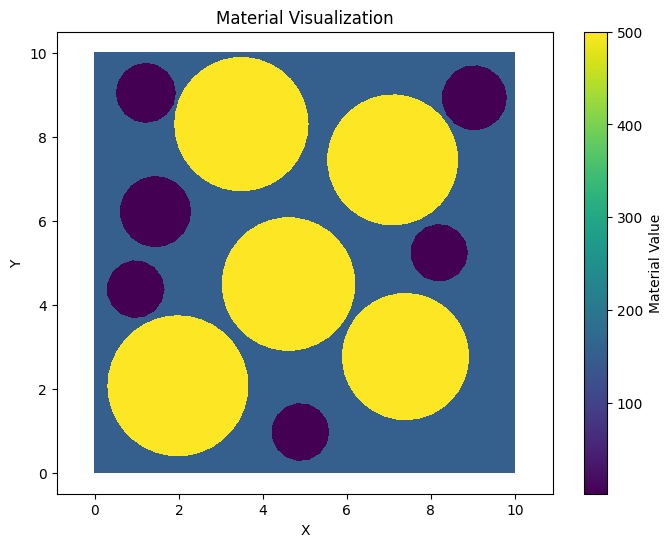

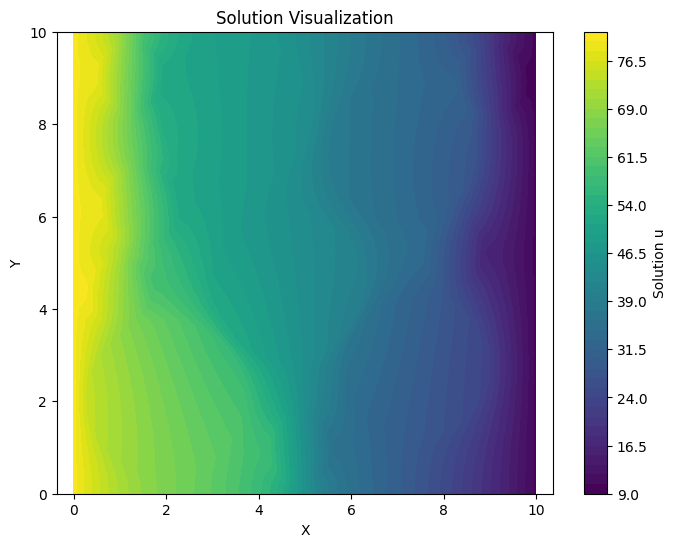

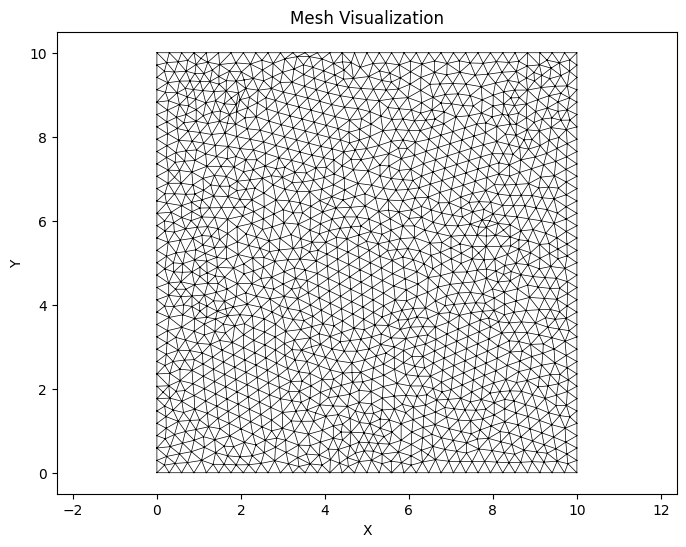

In [4]:
my_diffusion.plot_material()
my_diffusion.plot_state_function()
my_diffusion.plot_mesh()